In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def create_custom_matrix_beta(size, in_diag_alpha, in_diag_beta, out_diag_alpha, out_diag_beta):
    """
    Create a square matrix with different distributions for in-diagonal and out-diagonal elements
    in the range [0, 1].
    It takes as input: the size of the matrix, parameters for the in-diagonal elements and 
    parameters for the out-diagonal elements. 
    it returns the corresponding square matrix.
    """
    
    square_matrix = np.zeros((size, size))
    
    # Diagonal elements
    np.fill_diagonal(square_matrix, np.random.beta(in_diag_alpha, in_diag_beta, size))
    
    # Off-diagonal elements
    for i in range(size):
        for j in range(size):
            if i != j:
                square_matrix[i, j] = np.random.beta(out_diag_alpha, out_diag_beta)
                
    return square_matrix

def compute_cohens(group1, group2):

    # Means
    mean1, mean2 = np.mean(group1), np.mean(group2)

    # Variances
    variance1, variance2 = np.var(group1, ddof=1), np.var(group2, ddof=1)

    # Sample sizes
    n1, n2 = len(group1), len(group2)

    # Pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * variance1 + (n2 - 1) * variance2) / (n1 + n2 - 2))

    # Cohen's d
    d = (mean1 - mean2) / pooled_std

    return d

def mean_variance_to_alpha_beta(mean, variance):

    # Sum of alpha and beta
    alpha_plus_beta = (mean * (1 - mean) / variance) - 1
    
    # Alpha and beta
    alpha = mean * alpha_plus_beta
    beta = (1 - mean) * alpha_plus_beta
    
    return alpha, beta

def calculate_differential_identifiability(matrix):
    # Diagonal elements
    diagonal_elements = np.diag(matrix)
    # Off-diagonal elements
    off_diagonal_elements = matrix[np.triu_indices(matrix.shape[0], k=1)]
    
    # Average diagonal elements
    avg_within_subject_similarity = np.mean(diagonal_elements)
    # Average off-diagonal elements
    avg_between_subjects_similarity = np.mean(off_diagonal_elements)
    
    # Differential identifiability
    I_diff = avg_within_subject_similarity - avg_between_subjects_similarity
    
    return I_diff

def compute_crr(scores):
    dim = scores.shape[0]  # Number of subjects
    n_tests = 0            # Number of tests
    correct_recognitions = 0  # CRR

    for ep in range(dim):
        # Sort scores in descending order
        sorted_indices = np.argsort(scores[ep, :])[::-1]
        # print(sorted_indices)
        rank1 = sorted_indices[0]
        # print(rank1)

        # if the index of the highest score corresponds to the subject
        if rank1 == ep:
            correct_recognitions += 1  # Correct!
        n_tests += 1  # Counter for n of tests

    # CRR
    crr = correct_recognitions / n_tests
    return crr

def calculate_far_frr(scores_matrix, thresholds):
    genuine_scores = np.diag(scores_matrix)
    impostor_scores = scores_matrix[np.triu_indices(scores_matrix.shape[0], k=1)]
    
    FAR = []
    FRR = []
    
    for threshold in thresholds:
        # FAR
        far = np.mean(impostor_scores > threshold)
        # FRR
        frr = np.mean(genuine_scores < threshold)
        
        FAR.append(far)
        FRR.append(frr)
    
    return FAR, FRR

def find_eer(FAR, FRR, thresholds):
    abs_diff = np.abs(np.subtract(FAR, FRR))
    min_index = abs_diff.argmin()
    eer = (FAR[min_index] + FRR[min_index]) / 2
    eer_threshold = thresholds[min_index]
    
    return eer, eer_threshold

def calculate_dself_mean(matrix):
    participants = matrix.shape[0]
    dself_values = np.zeros(participants)
    lower_triangle_indices = np.tril_indices(participants, -1)
    std_dev = np.std(matrix[lower_triangle_indices])
    
    for p in range(participants):
        self_corr = matrix[p, p]
        other_corrs = np.delete(matrix[:, p], p)
        mean_other_corr = np.mean(other_corrs)
        dself = (self_corr - mean_other_corr) / std_dev
        dself_values[p] = dself
    
    return np.mean(dself_values)

In [21]:
# Main:

eer_values = []
idiff_values = []
cohens_values = []
dself_values = []
crr_values = []

step = 4
# Parameters for the simulation
in_mean_param = np.linspace(.5, .8, step)
in_var_param = np.linspace(.001, .09, step)
out_mean_param = np.linspace(.1, .4, step)
out_var_param = np.linspace(.001, .09, step)

size = 100

for in_mean in in_mean_param:
    for in_var in in_var_param:
        for out_mean in out_mean_param:
            for out_var in out_var_param:
                in_alpha, in_beta = mean_variance_to_alpha_beta(in_mean, in_var)
                out_alpha, out_beta = mean_variance_to_alpha_beta(out_mean, out_var)
                # print(f"in Alpha: {in_alpha}, in Beta: {in_beta}")
                # print(f"out Alpha: {out_alpha}, out Beta: {out_beta}")
                # My matrix
                matrix = create_custom_matrix_beta(size, in_alpha, in_beta, out_alpha, out_beta)

                # EER
                thresholds = np.linspace(0, 1, 100)
                FAR, FRR = calculate_far_frr(matrix, thresholds)
                EER, _ = find_eer(FAR, FRR, thresholds)

                # I_diff
                I_diff = calculate_differential_identifiability(matrix)
                
                # cohens
                # Diagonal and off-diagonal elements
                diagonal_elements = np.diag(matrix)
                off_diagonal_elements = matrix[np.triu_indices(size, k=1)]
                cohens_d = compute_cohens(diagonal_elements, off_diagonal_elements)
                
                # Calculate Dself mean
                dself_mean = calculate_dself_mean(matrix)
                
                # CRR
                crr = compute_crr(matrix)

                # Results
                eer_values.append(EER)
                idiff_values.append(I_diff)
                cohens_values.append(cohens_d)
                dself_values.append(dself_mean)
                crr_values.append(crr)
                

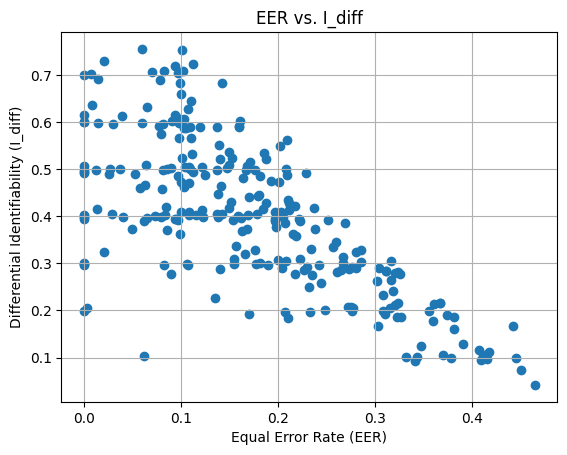

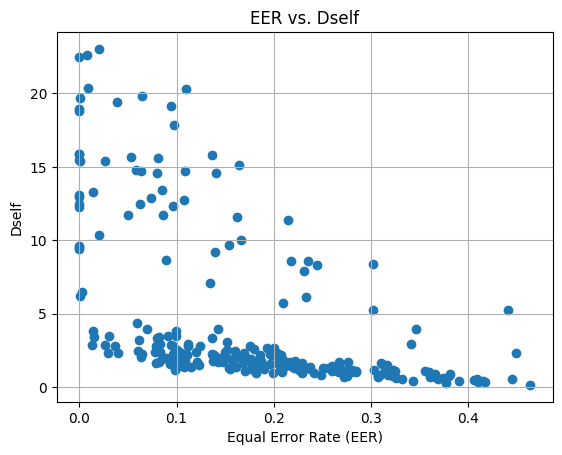

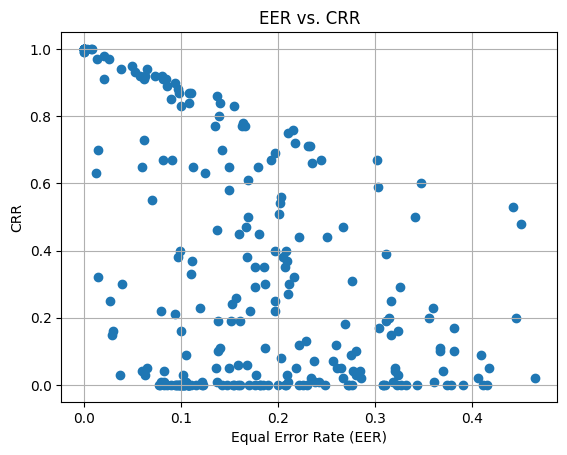

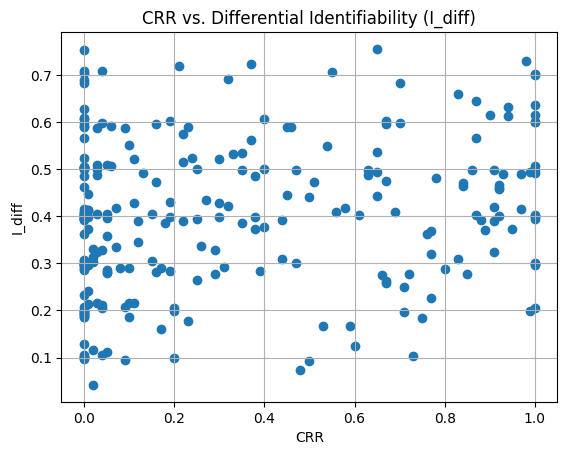

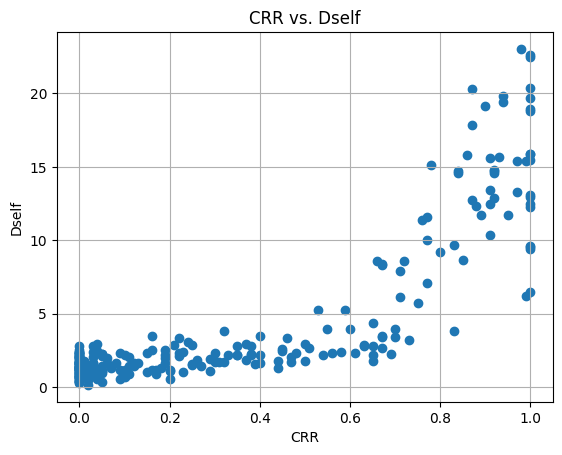

Pearson correlation coefficient between EER and I_diff: -0.706561582977973
Pearson correlation coefficient between EER and Dself: -0.5364416010023602


In [22]:
# Plot EER vs I_diff
plt.scatter(eer_values, idiff_values)
plt.xlabel('Equal Error Rate (EER)')
plt.ylabel('Differential Identifiability (I_diff)')
plt.title('EER vs. I_diff')
plt.grid(True)
plt.show()

# Plot EER vs Dself
plt.scatter(eer_values, dself_values)
plt.xlabel('Equal Error Rate (EER)')
plt.ylabel('Dself')
plt.title('EER vs. Dself')
plt.grid(True)
plt.show()

# Plot EER vs CRR
plt.scatter(eer_values, crr_values)
plt.xlabel('Equal Error Rate (EER)')
plt.ylabel('CRR')
plt.title('EER vs. CRR')
plt.grid(True)
plt.show()

# Plot CRR vs I_diff
plt.scatter(crr_values, idiff_values)
plt.xlabel('CRR')
plt.ylabel('I_diff')
plt.title('CRR vs. Differential Identifiability (I_diff)')
plt.grid(True)
plt.show()

# Plot CRR vs Dself
plt.scatter(crr_values, dself_values)
plt.xlabel('CRR')
plt.ylabel('Dself')
plt.title('CRR vs. Dself')
plt.grid(True)
plt.show()

# Pearson correlation coefficient
corr, _ = pearsonr(eer_values, idiff_values)
print(f"Pearson correlation coefficient between EER and I_diff: {corr}")
corr_01, _ = pearsonr(eer_values, dself_values)
print(f"Pearson correlation coefficient between EER and Dself: {corr_01}")

Genuine Scores: mean = 0.843, std_dev = 0.317
Impostor Scores: mean = 0.151, std_dev = 0.300
EER: 0.141 and I_diff: 0.692


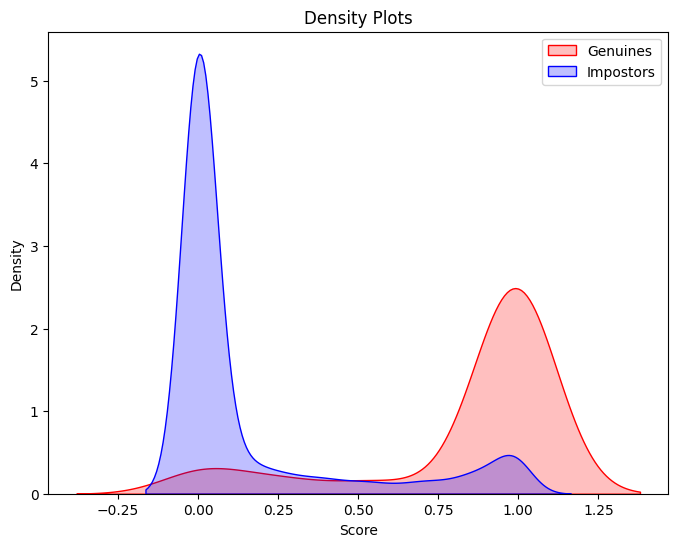

In [52]:
import seaborn as sns

eer_values = []
idiff_values = []

# Parameters for simulation
in_mean_param = .85
in_var_param = .09
out_mean_param = .15
out_var_param = .09


size = 100


in_alpha, in_beta = mean_variance_to_alpha_beta(in_mean_param, in_var_param)
out_alpha, out_beta = mean_variance_to_alpha_beta(out_mean_param, out_var_param)
# print(f"in Alpha: {in_alpha}, in Beta: {in_beta}")
# print(f"out Alpha: {out_alpha}, out Beta: {out_beta}")
# My matrix
matrix = create_custom_matrix_beta(size, in_alpha, in_beta, out_alpha, out_beta)

# EER
thresholds = np.linspace(0, 1, 100)
FAR, FRR = calculate_far_frr(matrix, thresholds)
EER, _ = find_eer(FAR, FRR, thresholds)

# I_diff
I_diff = calculate_differential_identifiability(matrix)

# Diagonal and off-diagonal elements
diagonal_elements = np.diag(matrix)
off_diagonal_elements = matrix[np.triu_indices(size, k=1)]

# Statistics for diagonal elements (genuine scores)
mean_diagonal = np.mean(diagonal_elements)
std_diagonal = np.std(diagonal_elements)

# Statistics for off-diagonal elements (impostor scores)
mean_off_diagonal = np.mean(off_diagonal_elements)
std_off_diagonal = np.std(off_diagonal_elements)

print(f"Genuine Scores: mean = {mean_diagonal:.3f}, std_dev = {std_diagonal:.3f}")
print(f"Impostor Scores: mean = {mean_off_diagonal:.3f}, std_dev = {std_off_diagonal:.3f}")
print(f"EER: {EER:.3f} and I_diff: {I_diff:.3f}")

# Results
eer_values.append(EER)
idiff_values.append(I_diff)

plt.figure(figsize=(8, 6))
sns.kdeplot(diagonal_elements, color='red', label='Genuines', fill=True)
sns.kdeplot(off_diagonal_elements, color='blue', label='Impostors', fill=True)
plt.title('Density Plots')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()
plt.show()